# Problem set 4: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 48 


## Resources from class

### APIs
- [Lecture slides](https://docs.google.com/presentation/d/1eblPOhpOL1HDFk3XOh3KvcrFceJ4pwZNUU_fvU8i7uo/edit#slide=id.p)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/06_apis_solutions.ipynb)


### Supervised ML
- [Lecture slides 1](https://docs.google.com/presentation/d/1V6X9aYkYLvyh3Ea0ZSn3qkttqKz7OOPkfvbqYybMi5Q/edit#slide=id.p)
- [Lecture slides 2](https://docs.google.com/presentation/d/13xJTI_GZ2HZYI9OSmezwLUXXFxIrjwHXKz50QUjBF0w/edit)
- [Intro activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://docs.google.com/presentation/d/1HHgrkFtuhGIaPNMd1EOiM-8VtgnF0cwjMcmah8oWmWA/edit?usp=sharing)
- [Example code](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: change SQL dataset

- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/herbertfreeze/QSS_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [7]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
import warnings
warnings.filterwarnings("ignore")

import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [8]:
# your code here 
naep_query_1 = (
# base link
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
#filters
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015')

naep_query_1
## use requests to call the api
naep_resp = requests.get(naep_query_1)
naep_resp
print(type(naep_resp))

## get the json contents of the response 
## here, we're assuming valid response
naep_resp_j = naep_resp.json()
naep_resp_j

## with result, turn it into a dataframe
naep_resp_d = pd.DataFrame(naep_resp_j['result'])
naep_resp_d

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'

<Response [200]>

<class 'requests.models.Response'>


{'status': 200,
 'result': [{'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 275.020976636682,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 275.638637274477,
   'isStatDisplayable': 1,
   'errorFlag': 0}]}

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0
1  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0

## Briefly interpret; what do scores look like between the genders?
- The scores between gender in the year 2015 look very similar. Both the females and males scores are 275, with the females being 0.61 higher at 275.63 compared to the males' 275.02. 

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [134]:
import requests
import pandas as pd


# Base URL and parameters
base_url = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?'
parameters = {
    'type': 'data',
    'subject': 'mathematics',
    'grade': 8,
    'subscale': 'MRPCM',
    'variable': 'GENDER',
    'jurisdiction': 'CA',
    'stattype': 'MN:MN'
}

# Years to retrieve
years = [2013, 2015, 2017, 2019]

# Initialize an empty list to store the data
all_data = []

# Loop through each year and make a request
for year in years:
    # Update the year in parameters
    parameters['Year'] = year
    
    # Create the query URL
    query_url = base_url + '&'.join([f"{key}={value}" for key, value in parameters.items()])
    
    # Make the request
    response = requests.get(query_url)
    
    if response.status_code == 200:
        data = response.json()
        
        # Assuming the structure of the data is known and extractable
        # Here we assume the response includes 'Results' key with relevant data
        results = data['result']
        
        # Add the year to the results
        for result in results:
            result['Year'] = year
        
        # Append the results to the all_data list
        all_data.extend(results)
    else:
        print(f"Failed to retrieve data for year {year}: {response.status_code}")

query1_2 = ('https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject'
'=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019')

# Create a DataFrame from all_data
df = pd.DataFrame(all_data)

# Print the DataFrame
df 

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag  Year
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  277.167171                  1          0  2013
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  274.597824                  1          0  2013
2  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0  2015
3  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0  2015
4  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  276.608704                  1          0  2017
5  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.669430                  1          0  2017
6  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  274.511628                  1          0  2019
7  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.721824                  1          0  2019

## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis minimum at 272 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Math Scores')

Text(0.5, 1.0, 'Variation in Math Scores Across Years for Male and Female Students')

(272.0, 280.0)

([<matplotlib.axis.XTick at 0x170cb0990>,
 [Text(2013, 0, '2013'),
  Text(2015, 0, '2015'),
  Text(2017, 0, '2017'),
  Text(2019, 0, '2019')])

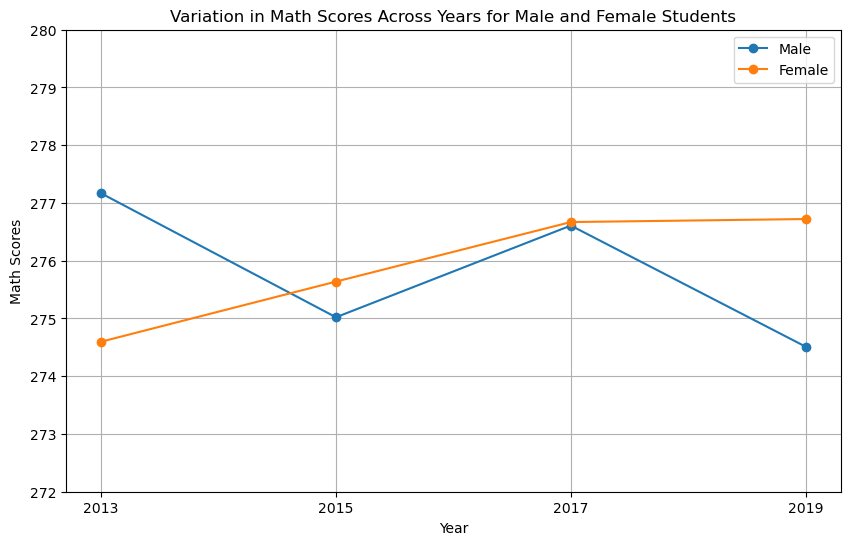

In [15]:
import matplotlib.pyplot as plt

# Filter data for male and female students
male_data = df[df['varValueLabel'] == 'Male']
female_data = df[df['varValueLabel'] == 'Female']

# Plotting
plt.figure(figsize=(10, 6))

# Plot for male students
plt.plot(male_data['Year'], male_data['value'], marker='o', linestyle='-', label='Male')

# Plot for female students
plt.plot(female_data['Year'], female_data['value'], marker='o', linestyle='-', label='Female')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Math Scores')
plt.title('Variation in Math Scores Across Years for Male and Female Students')
plt.legend()

# Set y-axis limit
plt.ylim(272, 280)

# Set x-axis ticks to show odd years only
plt.xticks([year for year in range(2013, 2020) if year % 2 != 0])

# Show grid
plt.grid(True)

# Show plot
plt.show()

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [137]:
# your code here to define function
def construct_naep_query(year, place):
    base_url = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction='

    year_str = ','.join(year) 
    
    return base_url + place + '&stattype=MN:MN&Year=' + year_str

In [138]:
# your code here to execute function for 1.1 
test1_1 = construct_naep_query(["2015"], "CA") 
assert test1_1 == naep_query_1, "failed"

# your code here to execute function for 1.2 
test1_2 = construct_naep_query(["2013", "2015", "2017", "2019"], "CA") 
assert test1_2 == query1_2, "failed"

## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/herbertfreeze/QSS_public/blob/main/activities/solutions/06_apis_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [24]:
# your code here
import requests
import pandas as pd

def process_naep_query(query):
    try:
        # Make the request
        response = requests.get(query)
        
        # Check if request was successful
        if response.status_code == 200:
            data = response.json()
            
            # Assuming the structure of the data is known and extractable
            # Here we assume the response includes 'Results' key with relevant data
            results = data['result']
            
            # Create DataFrame from results
            df = pd.DataFrame(results)
            return df
        else:
            return "Data not found; check your query"
    except Exception as e:
        return f"An error occurred: {str(e)}"

#Using the function below 
# Execute the function on the query that pulls 2013-2019 data
query_2013_2019 = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013&Year=2015&Year=2017&Year=2019'
df_2013_2019 = process_naep_query(query_2013_2019)
print("Data for 2013-2019:")
df_2013_2019 

# Execute the function on a query that pulls a state that doesn't exist (ZZ)
query_nonexistent_state = 'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=ZZ&stattype=MN:MN&Year=2013'
df_nonexistent_state = process_naep_query(query_nonexistent_state)
print("\nData for nonexistent state:")
print(df_nonexistent_state)


Data for 2013-2019:


year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  277.167171                  1          0
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  274.597824                  1          0
2  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0
3  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0
4  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  276.608704                  1          0
5  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.669430                  1          0
6  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  274.511628                  1          0
7  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.721824                  1          0


Data for nonexistent state:
An error occurred: Invalid control character at: line 1 column 101 (char 100)


# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=72395))

In [ ]:
creds = load_creds("PATH TO YOUR CREDS FILE")

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [ ]:
# your code here

## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [ ]:
# your code here

## Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?
- type here

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [ ]:
# your code here

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [ ]:
# your code here

## B. Print the resulting dataframe and interpret the results
- type here. 

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

In [ ]:
# your code here

## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_voter` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_voter` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [ ]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]

In [ ]:
## your code here


## C. Interpret: Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?
- type here.

## interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?
- type here. 

# 3. Explore variation in math score disparities and trends (18 points)

## 3.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [35]:
import pandas as pd

# Read the pickled DataFrame
acs_wmath_df = pd.read_pickle('acs_wmath.pkl')
acs_wmath_df

math_female_2013  math_female_2015  math_female_2017  math_female_2019  math_male_2013  math_male_2015  math_male_2017  math_male_2019 abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  \
0         281.388243        280.879362        276.557200        271.915723      281.723376      280.143705      277.451445      276.639877     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986   
1         268.920112        266.810672        266.748589        270.473059      269.457456      266.304405      269.820070      267.093325     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773   
2         278.381788        274.793326        273.139254        276.007484      277.457662      275.325959      274.352754      272.827299     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808   
3         279.249581        282.593875        279.935438        280.527631      280.174389      283.229891      284.522633      279.359156     AZ   04                                                                                                                                              

## 3.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


<Figure size 1200x800 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 0, 'State')

Text(0, 0.5, 'Gender Disparity (Male - Female Math Scores)')

Text(0.5, 1.0, 'Gender Disparity in 2013 Math Scores by State')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Alaska'),
  Text(1, 0, 'Alabama'),
  Text(2, 0, 'Arkansas'),
  Text(3, 0, 'Arizona'),
  Text(4, 0, 'California'),
  Text(5, 0, 'Colorado'),
  Text(6, 0, 'Connecticut'),
  Text(7, 0, 'Delaware'),
  Text(8, 0, 'Florida'),
  Text(9, 0, 'Georgia'),
  Text(10, 0, 'Hawaii'),
  Text(11, 0, 'Iowa'),
  Text(12, 0, 'Idaho'),
  Text(13, 0, 'Illinois'),
  Text(14, 0, 'Indiana'),
  Text(15, 0, 'Kansas'),
  Text(16, 0, 'Kentucky'),
  Text(17, 0, 'Louisiana'),
  Text(18, 0, 'Massachusetts'),
  Text(19, 0, 'Maryland'),
  Text(20, 0, 'Maine'),
  Text(21, 0, 'Michigan'),
  Text(22, 0, 'Minnesota'),
  Text(23, 0, 'Missouri'),
  Text(24, 0, 'Mississippi'),
  Text(25, 0, 'Montana'),
  Text(26, 0, 'North Car

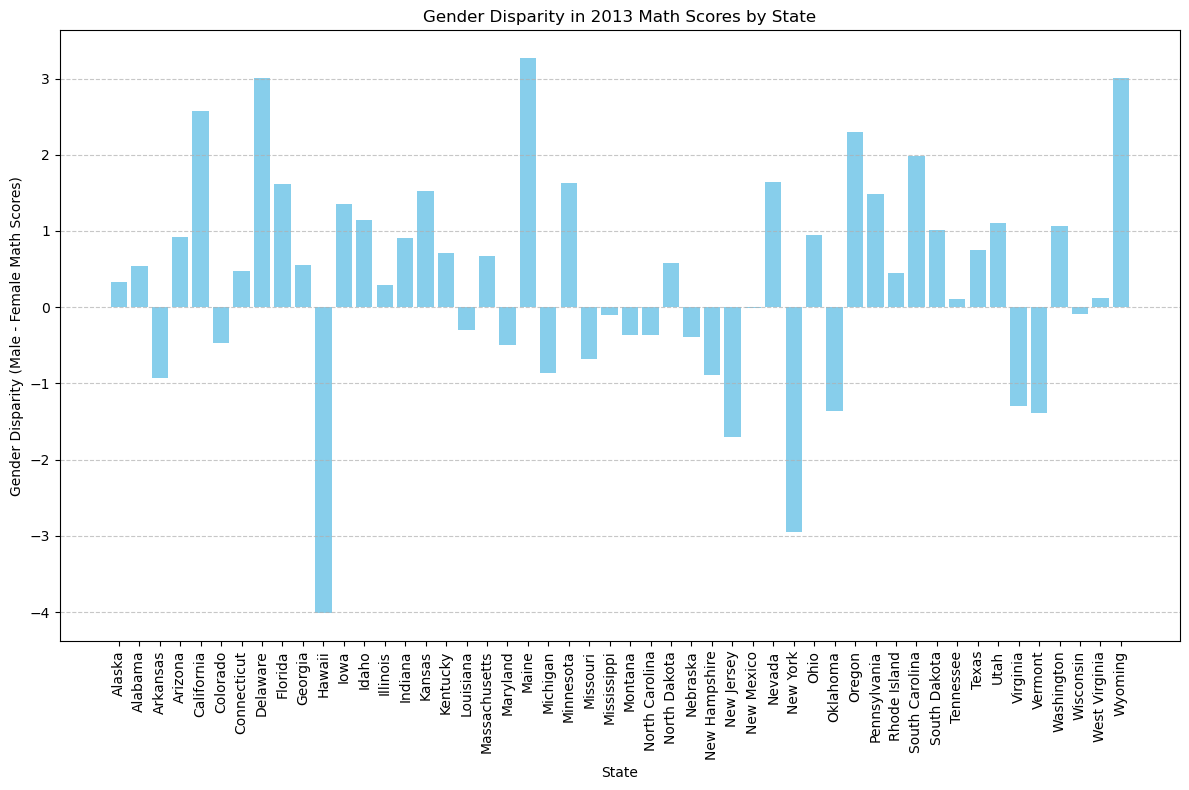

In [54]:
import matplotlib.pyplot as plt

# Filter data for 2013 and calculate the gender disparity
acs_wmath_df["gender_disparity"] = acs_wmath_df['math_male_2013'] - acs_wmath_df['math_female_2013']
states = acs_wmath_df['state']


# Plotting
plt.figure(figsize=(12, 8))
plt.bar(states, gender_disparity, color='skyblue')
plt.xlabel('State')
plt.ylabel('Gender Disparity (Male - Female Math Scores)')
plt.title('Gender Disparity in 2013 Math Scores by State')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

## 3.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a scatterplot (or seaborn regplot) of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

In [55]:
# your code here
# Create the indicator variable
acs_wmath_df['gmales_tfemales'] = acs_wmath_df['gender_disparity'] > 0

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', ylabel='math_male_2013'>

Text(0.5, 0, 'Estimated Median Household Income')

Text(0, 0.5, 'Math Scores (Male 2013)')

Text(0.5, 1.0, 'Median Household Income vs Male 2013 Math Scores')

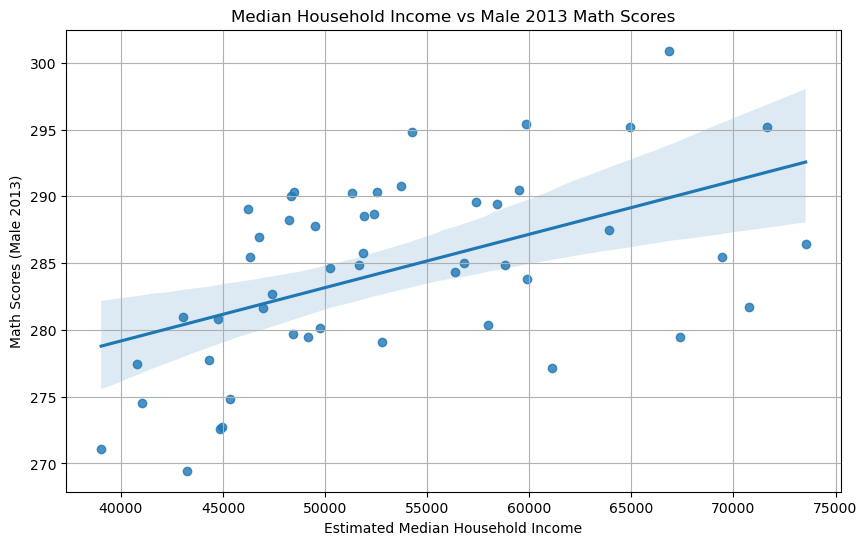

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', ylabel='math_female_2013'>

Text(0.5, 0, 'Estimated Median Household Income')

Text(0, 0.5, 'Math Scores (Female 2013)')

Text(0.5, 1.0, 'Median Household Income vs Female 2013 Math Scores')

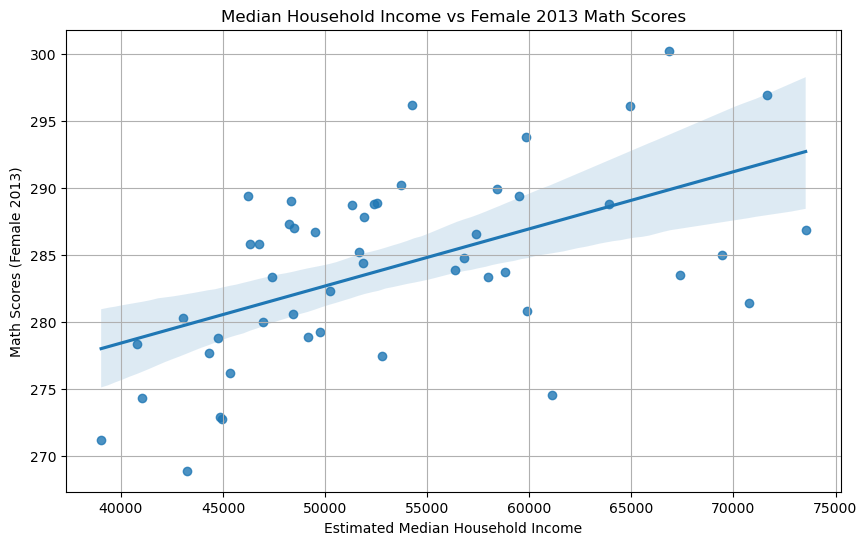

In [56]:
import seaborn as sns

# First scatterplot for math_male_2013
plt.figure(figsize=(10, 6))
sns.regplot(x='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', 
            y='math_male_2013', data=acs_wmath_df)
plt.xlabel('Estimated Median Household Income')
plt.ylabel('Math Scores (Male 2013)')
plt.title('Median Household Income vs Male 2013 Math Scores')
plt.grid(True)
plt.show()

# Second scatterplot for math_female_2013
plt.figure(figsize=(10, 6))
sns.regplot(x='acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars', 
            y='math_female_2013', data=acs_wmath_df)
plt.xlabel('Estimated Median Household Income')
plt.ylabel('Math Scores (Female 2013)')
plt.title('Median Household Income vs Female 2013 Math Scores')
plt.grid(True)
plt.show()

In [57]:
import numpy as np

# Correlation for male performance
correlation_male = np.corrcoef(acs_wmath_df['math_male_2013'], acs_wmath_df['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])[0, 1]

# Correlation for female performance
correlation_female = np.corrcoef(acs_wmath_df['math_female_2013'], acs_wmath_df['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])[0, 1]

# Correlation for the indicator variable
correlation_indicator = np.corrcoef(acs_wmath_df['gmales_tfemales'], acs_wmath_df['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])[0, 1]

print("Correlation for male performance:", correlation_male)
print("Correlation for female performance:", correlation_female)
print("Correlation for the indicator variable:", correlation_indicator)

Correlation for male performance: 0.5073471931940418
Correlation for female performance: 0.54337803495893
Correlation for the indicator variable: -0.03387519833365422


## D. Interpret the correlations - in states with higher median household income (MHI), do 1) boys tend to perform better than boys in states with lower MHI? 2) girls tend to perform better than girls in states with lower MHI? 3) boys tend to outperform girls more than they do in states with lower MHI?
- The positive correlation (0.51) between male performance and median household income suggests that in states with higher median household income, boys tend to perform better than in states with lower median household income. There is also positive correlation on the female side (0.54), which suggests that in states with higher median household income, girls tend to perform better than in states with lower median household income. The indicator variable and median household income indicates whether the states where boys tend to perform better than girls coincide with states with higher median household income. This correlation is negative, which suggests that in states with higher median household income, boys did not tend to outperform girls more than they do in states with lower median household income; rather it was the girls who were seen to outpreform the boys in these states with a higher median household income. 

## 3.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019). With 50 states, your final shape should be (200,84).
- See: https://pandas.pydata.org/docs/reference/api/pandas.melt.html

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. Your covariates should have the term 'acspredict' in it.

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [61]:
# A. your code here to load data
import pandas as pd

# Read the pickled DataFrame
acs_wmath_df_1 = pd.read_pickle('acs_wmath.pkl')

In [64]:
# B. your code here to construct binary indicators for male higher
# Define the years
years = [2013, 2015, 2017, 2019]

# Iterate over the years
for year in years:
    # Create the indicator variable for the specific year
    indicator_col_name = f'outcome_male_higher_female_{year}'
    acs_wmath_df_1[indicator_col_name] = (acs_wmath_df_1[f'math_male_{year}'] > acs_wmath_df_1[f'math_female_{year}']).astype(int)

#Filter out columns with the word 'math'
acs_wmath_df_1 = acs_wmath_df_1.loc[:, ~acs_wmath_df_1.columns.str.contains('math')]

#Display the outcome 
acs_wmath_df_1

abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0      AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
1      AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
2      AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808                                                                                                                                                         0.026058   
3      AZ   04                                                                                                                                                                                 

In [145]:
# C. your code here to melt data
columns = list(acs_wmath_df_1.columns)
id_vars = [col for col in columns if 'outcome_male_higher' not in col]
acs_wmath_long = pd.melt(acs_wmath_df_1, id_vars = id_vars, value_vars = 
                         ["outcome_male_higher_female_2013", "outcome_male_higher_female_2015", 
                          "outcome_male_higher_female_2017","outcome_male_higher_female_2019"],
                        value_name = "outcome_male_higher")

acs_wmath_long
acs_wmath_long.shape

abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0       AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
1       AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
2       AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808                                                                                                                                                         0.026058   
3       AZ   04                                                                                                                                                                             

(200, 86)

In [150]:
# D. your code here for train/test split
unique_states = acs_wmath_long['state'].unique()
train_states = set(pd.Series(unique_states).sample(n=35, random_state=15))
test_states = set(unique_states) - train_states

# Split the data based on selected states into the training and test sets
train_data = acs_wmath_long[acs_wmath_long['state'].isin(train_states)]
test_data = acs_wmath_long[acs_wmath_long['state'].isin(test_states)]

In [174]:
# E. your code here to normalize features and fit model
from sklearn.preprocessing import StandardScaler 

train_x = train_data.drop(["state", "outcome_male_higher", "variable", "abbrev", "FIPS"], axis=1) 
train_y = train_data["outcome_male_higher"]

test_x = test_data.drop(["state", "outcome_male_higher", "variable", "abbrev", "FIPS"], axis=1) 
test_y = test_data["outcome_male_higher"] 

standard = StandardScaler().fit(train_x) 
standardizedTrain_data = standard.transform(train_x) 
standardizedTest_data = standard.transform(test_x) 

from sklearn.tree import DecisionTreeClassifier 
tree = DecisionTreeClassifier(max_depth = 5).fit(standardizedTrain_data, train_y) 
tree 

importance_df = pd.DataFrame([train_x.columns, tree.feature_importances_]).T
importance_df.columns = ["feature", "importance"]
importance_df.sort_values("importance", ascending = False) 

DecisionTreeClassifier(max_depth=5)

feature importance
32                                                                                                                  acspredict_household_type__including_living_alone__by_relationshipestimatetotalin households    0.31649
26                                                                                                             acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school   0.230594
41                                                                             acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdshouseholderfemale   0.145362
11                                                                                                                  acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade   0.079452
46                                                                acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsnonrelativesother nonrelatives    0.06643
35                                                                                         acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdschild   0.062621
31                                                                                                              acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters   0.033951
65                                                             acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdsnonrelativesother nonrelatives   0.025868
49                                                                               acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsother relatives   0.024143
38                                                                                acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdschildstepchild   0.015089
53                                                                                        acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsspouse        0.0
57                                                              acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholderfemaleliving alone        0.0
56                                                                          acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholderfemale        0.0
55                                                                                acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholder        0.0
54                                                                                           acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily households        0.0
0            acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated        0.0
52                                                                     acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdssoninlaw or daughterinlaw        0.0
59                                                                            acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholdermale        0.0
51                   

## F. interpret feature importances
- Based on the feature importances, there appear to be 10 categories that are important to males scoring better on the math test than females. Most of those factors fall into categories concerning the makeup of a household and educational attainment. For instance, the model suggests that the most significant predictor is the total number of people living in the household, and other significant household-type predictors include the presence of female householders, the presence of other relatives and nonrelatives, and the presence of children in the household. The importance of these features suggest that the specific composition of the household importantly influences individuals' testscores and whether males outperform females. Similarly, the model suggests that individuals' early educational experiences have notable impact on their test scores, as features with non-zero importances in this category include educational attainment of nursery school and second grade. Therefore, the model implies that environmental factors like the households in which individuals are raised and their early educational experiences play a role their test performance/scores. 

## F. interpret feature importances
- Based on the feature importances, there appear to be 10 categories that are important to males scoring better on the math test than females. Most of those factors are the makeup of a household and education availability, educational attainment, and children or non-realtives in the house, etc. These enviornmental factors could impact the test scores of an individual. 

In [188]:
# G. your code here to evaluate model
predictions = tree.predict(standardizedTest_data)

TP = np.sum(np.logical_and(predictions == 1, test_y == 1))  
TN = np.sum(np.logical_and(predictions == 0, test_y == 0))  
FP = np.sum(np.logical_and(predictions == 1, test_y == 0))  
FN = np.sum(np.logical_and(predictions == 0, test_y == 1)) 

score = (TP + TN) / (TP + TN + FP + FN) 
precision = TP / (TP + FP) 
recall = TP / (TP + FN) 

print("score: " + str(score)) 
print("precision: " + str(precision)) 
print("recall: " + str(recall)) 

#for each state for each year it makes a prediction about if the males will in fact score higher than the females on the math test 

score: 0.55
precision: 0.6666666666666666
recall: 0.45714285714285713


## G. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?
- Our model may performance worse than our class example because of the size of our data. Our in-class exaple had ~15,000 observations and our model within the problem set had ~200, including varience of the year. This difference in sample size makes it more difficult for our problem sets' model to make predictions because it is so limited in the data it is basing those predictions off of. 